In [90]:
import numpy as np
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import time
import scipy.stats as stats
from scipy.stats import genextreme
import skextremes as ske 
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

%matplotlib inline


In [2]:
# Loading dataset
data = pd.read_excel('base_xy.xlsx')
base_x = pd.DataFrame(data).drop(['Y'], axis = 1)
base_y = pd.DataFrame(data).drop(['X'], axis = 1)
data.head(10)

,date,X,Y
0,1972-12-01,18219.399154,3893.256682
1,1973-01-01,3393.650671,2051.995156
2,1973-02-01,10067.730309,3221.288227
3,1973-03-01,3412.591415,1709.404472
4,1973-04-01,12492.402434,3690.221824
5,1973-05-01,10042.917392,2911.612373
6,1973-06-01,12626.372102,3430.840450
7,1973-07-01,14255.993903,4069.606710
8,1973-08-01,15692.515583,3946.018390
9,1973-09-01,1444.757635,1741.189926


In [101]:
## Inspection primaire des données (Portefeuille X) 
print("Statistiques de base:\nnombre d'observations = {} \
\nmoyenne = {} \necart-type = {} \nmin = {} \nmax = {} \nkurtosis = {} \nskewness = {} "
      .format(len(data), np.mean(data['X']), np.std(data['X']), 
              np.min(data['X']), np.max(data['X']), stats.kurtosis(data['X']), stats.skew(data['X'])))

Statistiques de base:
nombre d'observations = 598 
moyenne = 8836.301719970541 
ecart-type = 6854.673107261387 
min = 416.19587625048445 
max = 88523.0 
kurtosis = 34.310585012083926 
skewness = 3.910184513195929 


En terme de pertes mensuelles sur le portefeuille X, on peut remarquer que notre distribution a une skewness positive , ce qui veut dire la queue de distribution est etalée à droite. Par ailleurs, la kurtosis est de loin plus elevée que la kurtosis d'une loi normale, en d'autres termes on affaire ici a des pertes extrêmes plus fréquentes que dans le cas d'une distribution normale. L'ecart entre la perte maximum et la perte minimum est très elevé, ce qui veut dire... 

##  Adéquation X à la loi normale 

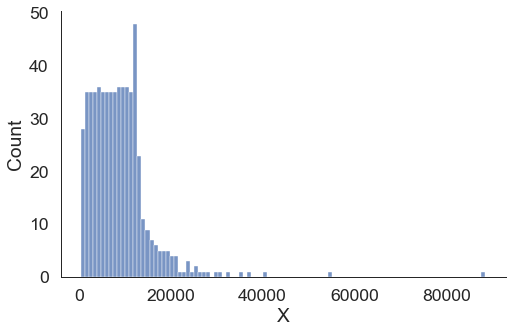

In [15]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=data, x="X", kind="hist", bins = 100, aspect = 1.5)

Fitting 2 distributions: 100%|███████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.44it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,7.278230e-09,5859.068653,-15009.736603,inf,0.108688,1.317199e-06
norm,8.534303e-09,6033.296684,-14920.925006,inf,0.125104,1.287769e-08


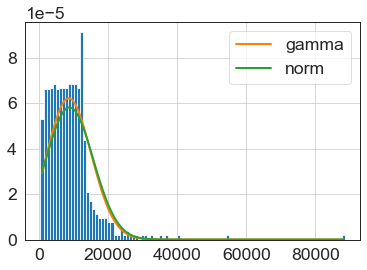

In [9]:
X = base_x['X']
model = Fitter(X,
           distributions=['gamma',
                          "norm"])
model.fit()
model.summary()

Très mauvaise adéquation !! 

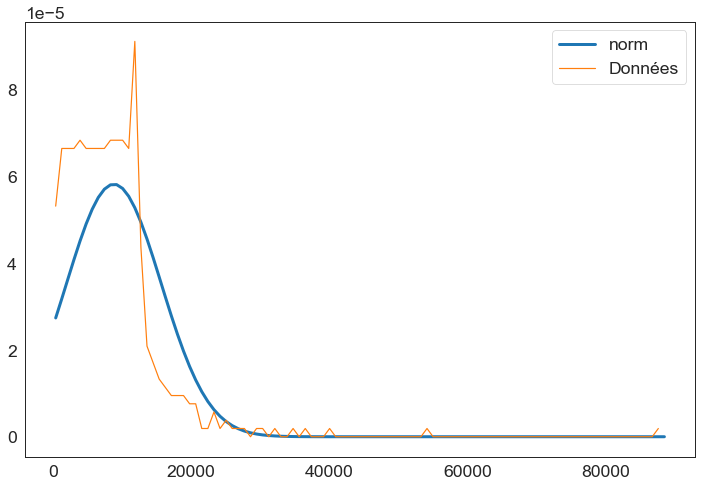

In [11]:

dist_name = "norm"

y, x = np.histogram(X, bins=100, density=True)

# Paramètres de la loi
dist = getattr(scipy.stats, dist_name)

# Modéliser la loi
param = dist.fit(X) 

loc = param[-2]
scale = param[-1]
arg = param[:-2]

pdf = dist.pdf(x, loc=loc, scale=scale, *arg)

plt.figure(figsize=(12,8))
plt.plot(x, pdf, label=dist_name, linewidth=3) 
plt.plot(x[0:-1], y, label="densité empirique")
plt.legend()
plt.show()

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

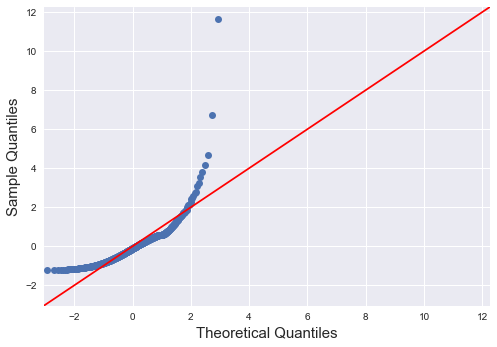

In [18]:
## QQ-Plot
import statsmodels.api as sm
sm.qqplot(X,fit=True,line='45', dist=stats.norm)
plt.show()

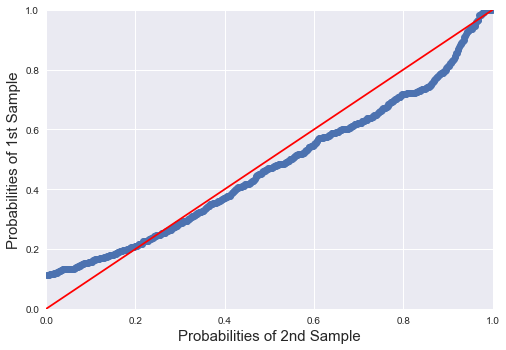

In [33]:
# PP- Plot 
y = np.random.normal(loc=loc, scale=scale, size=len(X))
pp_x = sm.ProbPlot(X, fit=True)
pp_y = sm.ProbPlot(y, fit=True)
fig = pp_x.ppplot(line='45', other=pp_y)
plt.show()

## Modélisation de X par une GEV

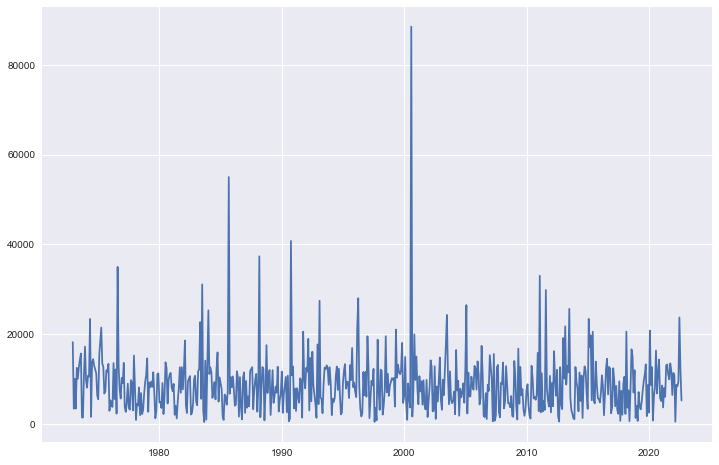

In [94]:
## Visualisation 
plt.figure(figsize=(12,8))
plt.plot(base_x['date'], base_x['X'])

In [106]:
shape

-0.4729447382054863

Statistiques de base:
nombre d'observations = 51 
moyenne = 21704.364443482507 
ecart-type = 12665.347381600983 
indice de queue = -0.4729447382054863 
min = 10890.192519395234 
max = 88523.0 
kurtosis = 13.392803907486297 
skewness = 3.276961280750333 


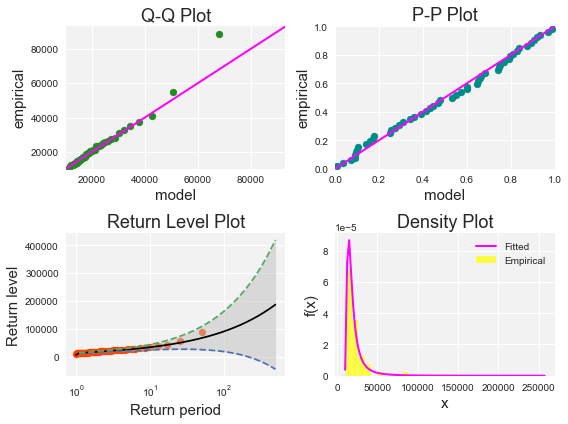

In [109]:
## Maximum par année 
per = data.date.dt.to_period("Y")
maxima_years = data.groupby(per).max()
X = np.array(maxima_years['X'])
model = ske.models.classic.GEV(X, fit_method = 'mle', ci = 0.05, ci_method = 'delta') 
shape, loc, scale = model.params["shape"], model.params["location"], model.params["scale"]

## Stats de base 
print("Statistiques de base:\nnombre d'observations = {} \
\nmoyenne = {} \necart-type = {} \nindice de queue = {} \nmin = {} \nmax = {} \nkurtosis = {} \nskewness = {} "
      .format(len(X), np.mean(X), np.std(X), shape,
              np.min(X), np.max(X), stats.kurtosis(X), stats.skew(X)))


model.plot_summary()
plt.show()

Statistiques de base:
nombre d'observations = 200 
moyenne = 14098.482613225577 
ecart-type = 8457.241796462631 
indice de queue = -0.12019476033760809 
min = 2266.693970267139 
max = 88523.0 
kurtosis = 31.264949582939487 
skewness = 4.447673173684864 


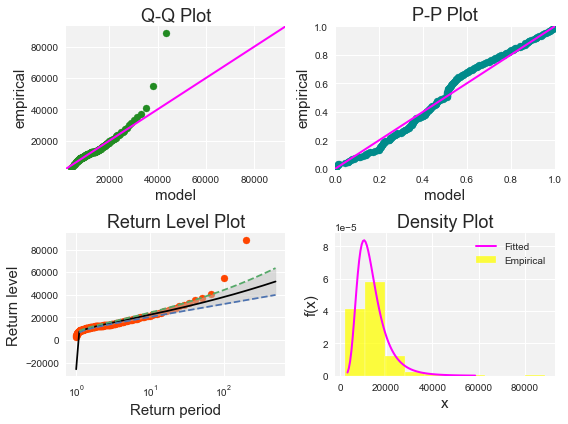

In [110]:
## Maximum par trimèstre 
per = data.date.dt.to_period("Q")
maxima_trimest = data.groupby(per).max()
X = np.array(maxima_trimest['X'])
model = ske.models.classic.GEV(X, fit_method = 'mle', ci = 0.05, ci_method = 'delta') 
shape, loc, scale = model.params["shape"], model.params["location"], model.params["scale"]

print("Statistiques de base:\nnombre d'observations = {} \
\nmoyenne = {} \necart-type = {} \nindice de queue = {} \nmin = {} \nmax = {} \nkurtosis = {} \nskewness = {} "
      .format(len(X), np.mean(X), np.std(X), shape,
              np.min(X), np.max(X), stats.kurtosis(X), stats.skew(X)))

model.plot_summary()
plt.show()

Statistiques de base:
nombre d'observations = 100 
moyenne = 17573.8011052004 
ecart-type = 10375.965759309747 
indice de queue = -0.29876139982491895 
min = 7091.219418018235 
max = 88523.0 
kurtosis = 21.22385700822962 
skewness = 3.9034166086010473 


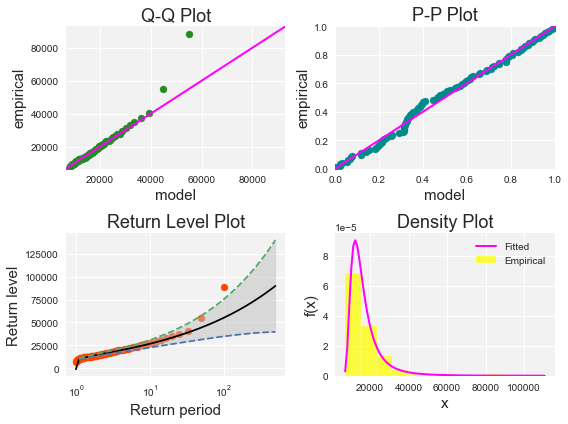

In [111]:
## Maximum par semèstre 
num = list(np.arange(100))*6
num.sort()

data['half year'] = num[0:598]

maxima_sm = data.groupby("half year").max()
X = np.array(maxima_sm['X'])
model = ske.models.classic.GEV(X, fit_method = 'mle', ci = 0.05, ci_method = 'delta') 
shape, loc, scale = model.params["shape"], model.params["location"], model.params["scale"]

print("Statistiques de base:\nnombre d'observations = {} \
\nmoyenne = {} \necart-type = {} \nindice de queue = {} \nmin = {} \nmax = {} \nkurtosis = {} \nskewness = {} "
      .format(len(X), np.mean(X), np.std(X), shape,
              np.min(X), np.max(X), stats.kurtosis(X), stats.skew(X)))

model.plot_summary()
plt.show()

In [93]:
## Période de rerour, en retenant le premier modèle (maximum par année) 

return_periods = np.array([20, 50, 100, 200])
return_levels = genextreme.isf(1/return_periods, shape, loc, scale) 

print("Return levels:")
print()
print("Period    Level")
print("(years)   (temp)")

for period, level in zip(return_periods, return_levels):
    print(f'{period:4.0f}  {level:9.2f}')

Return levels:

Period    Level
(years)   (temp)
  20   45354.67
  50   66960.51
 100   90680.72
 200  123540.57
